# Advanced statistics. Lab 1

**Name**: Ayhem Bouabid

## Import of the necessary modules

In [105]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable, Union, Callable, Tuple

VECTOR = Union[Iterable[Union[float, int]], np.ndarray]
NUM = Union[float, int]

import random
random.seed(100)
np.random.seed(100)

## Helper Functions 

In [106]:
def _is_one_dim(x: VECTOR) -> None:
    # making sure the input is one dimensional...
    # avoiding pythin tricky run time errors
    if isinstance(x, np.ndarray):
        x = x.squeeze()
        assert x.ndim == 1, "Make sure to pass one dimensional vector"
    
def func_sum(x: VECTOR) -> NUM:
    _is_one_dim(x)
    # a function to compute the sum of elements in a vector
    res = 0
    for v in x:
        res += v
    return res

def func_mean(x: VECTOR) -> NUM:
    # a function to compute the mean of a vector
    _is_one_dim(x)
    return func_sum(x) / len(x)


def uniform_random_array(low: NUM, high: NUM, n_samples: int, dimensions: int) -> np.ndarray:
    # np.random.rand produces random values between 0 and 1.
    # need to be scaled based on the values of low and high
    res = low + (high - low) * np.random.rand(n_samples, dimensions)
    assert res.shape == (n_samples, dimensions), "Make sure the shape is correct"
    assert np.all(res <= high)
    assert np.all(res >= low)
    return res

def func_mse(estimations: VECTOR, true_val: NUM) -> NUM:
    # step1. compute residuals
    residuals = [(e - true_val) ** 2 for e in estimations]
    # step2: average them
    avg_res = func_mean(residuals)
    # step3: sqrt
    return math.sqrt(avg_res)

# Numerical Integration

Numerically approximate integrals of the following forms: 

$$\int_a^b \int_a^b ... \int_a^b g(x_1, x_2, ..., x_d) ~ dx_1 d x_2 ... dx_d$$ 

where $g$ is $\mathbb{R}^ d \rightarrow \mathbb{R}$ function. 

The Monto-Carlo integration can be performed as follows: 

1. Sample $N$ random points uniformly distributed in the hypercube $[a, b] ^ d$. Each point $x_i$ is a $d$ -dimensional vectors.
2. Estimate the integrate as follows: 
    $$ I_{approx} = \frac{\sum_{i = 1}^N g(x_i)}{N} \cdot (b - a) ^ d$$
 


In [107]:
def approximate_integral(g: Callable, low: NUM, high: NUM, n_samples: int, dimensions: int, true_val: NUM) -> Tuple[NUM, NUM]:
    # step 1. generate: N random points
    points = uniform_random_array(low=low, high=high, n_samples=n_samples, dimensions=dimensions)

    # step 2: calculate g(x_i) for all points: each row in the 'points' array represents a point

    g_xi = np.apply_along_axis(g, 1, points)

    assert g_xi.shape == (n_samples,), f"make sure the function is applied correctly. Found: {g_xi.shape}"

    # step3: average g(x_i)
    avg = func_mean(g_xi)

    # step4: scale 
    estimation = avg * ((high - low) ** dimensions)

    # step 5: compute mse
    mse = func_mse(g_xi, true_val)

    return estimation, mse


Let's test the implementation with an example

$$
I = \int_a^b \int_a^b ... \int_a^b (\sum_{i = 1}^{d} x_i) ^ 2 ~ dx_1 d x_2 ... dx_d
$$ 

this integral is known to have the value of $I = \frac{d}{12}$

In [108]:
def sample_func(x: VECTOR) -> NUM:
    return func_sum(x) ** 2

def test_implementation(n_samples: int, dim: int) -> Tuple[NUM, NUM]:
    true_val = dim / 12
    return approximate_integral(g=sample_func, low=-0.5, high=0.5, n_samples=n_samples, dimensions=dim, true_val=true_val)

The `approximate_integral` function takes 5 arguments: 

1. the function whose integral is to be approximated: $g$
2. the lower bound
3. the upper bound
4. number of samples
5. the dimensions of the input to $g$

The first 3 were set by the problem statement. Hence, we have only 2 free arguments: number of samples and input dimension.

## Effect of Number of samples

In [109]:
# from 10 to 10010
START = 10
END = 10010
NUM_SAMPLES = [START + 100 * i for i in range(0, (END - START) // 100)]
print(len(NUM_SAMPLES))

100


In [110]:
DIM = 3
TRUE_VAL = DIM / 12
test_results = [test_implementation(n_samples=n, dim=DIM) for n in NUM_SAMPLES]
estimations, mses = [abs(x[0] - TRUE_VAL) for x in test_results], [x[1] for x in test_results]

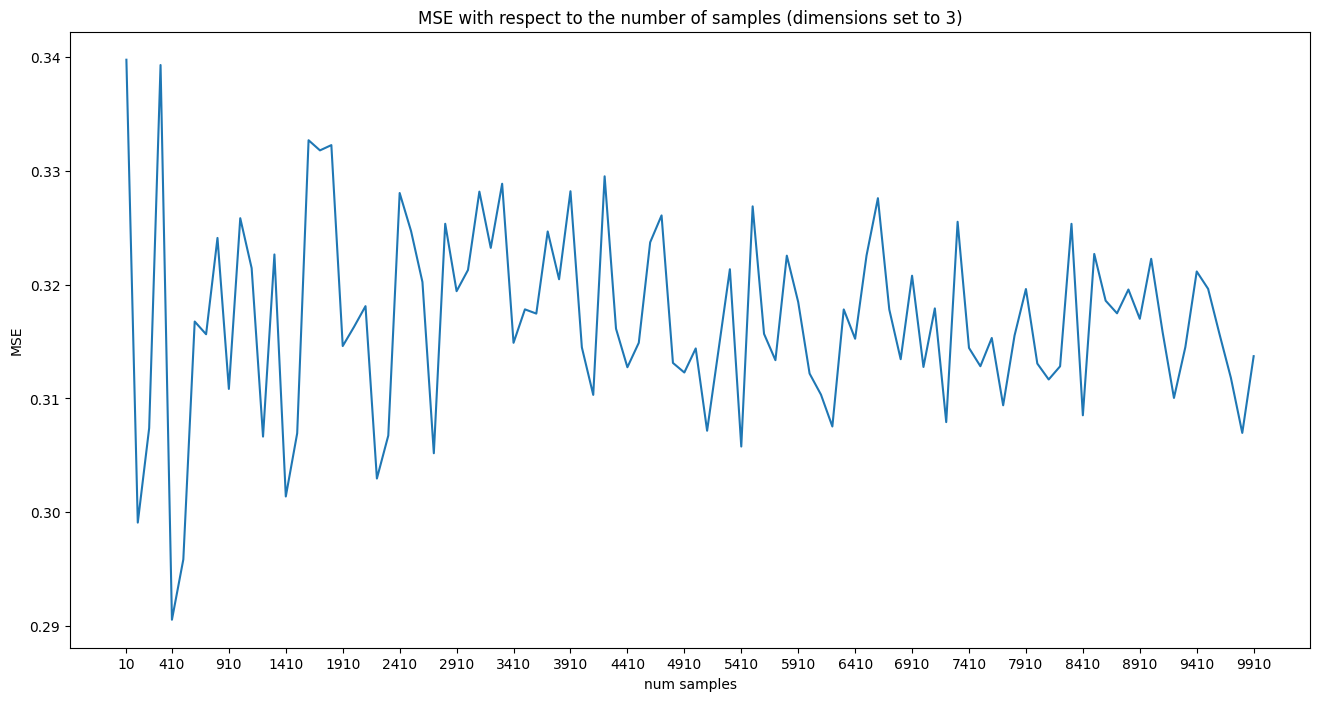

In [111]:
plt.figure(figsize=(16, 8))
plt.plot(NUM_SAMPLES, mses)
plt.title(f'MSE with respect to the number of samples (dimensions set to {DIM})')
plt.ylabel('MSE')
plt.xlabel('num samples')
plt.xticks([NUM_SAMPLES[int(i)] for i in np.linspace(0, len(NUM_SAMPLES) - 1, 21)])
plt.show()

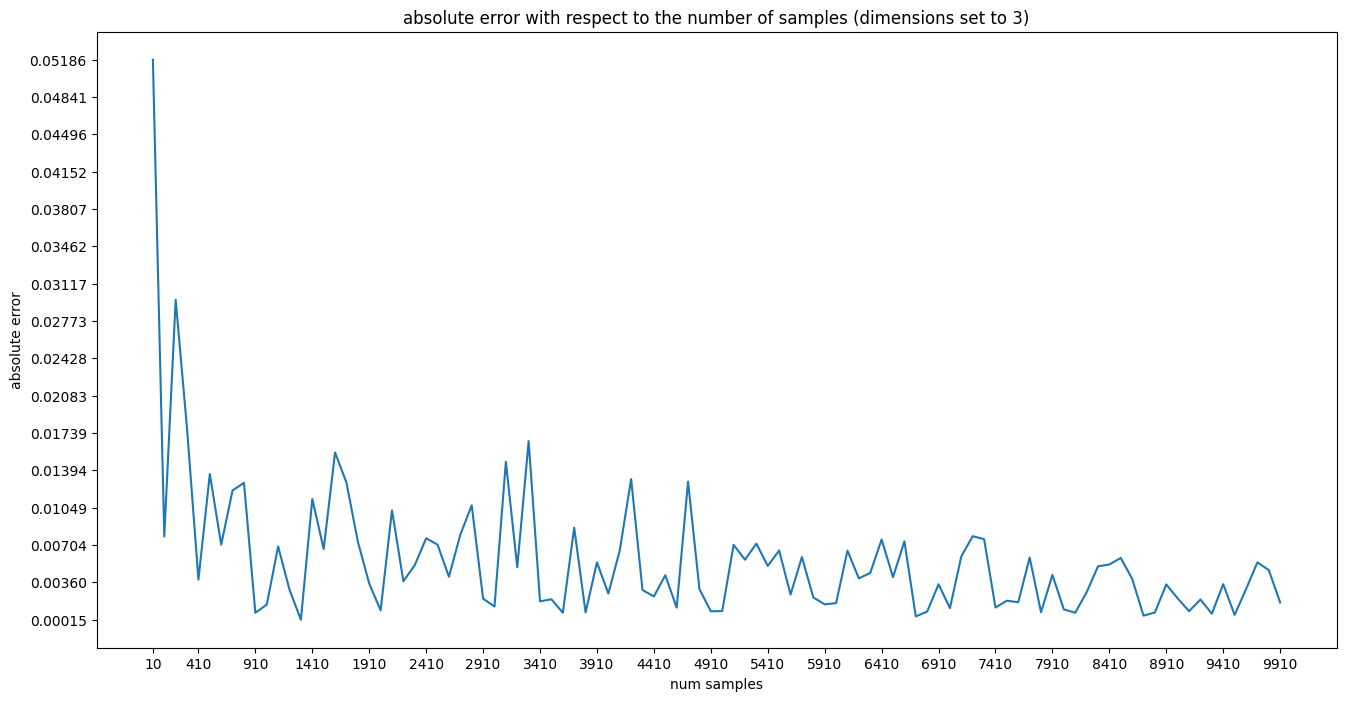

In [112]:
plt.figure(figsize=(16, 8))
plt.plot(NUM_SAMPLES, estimations)
plt.title(f'absolute error with respect to the number of samples (dimensions set to {DIM})')
plt.ylabel('absolute error')
plt.xlabel('num samples')
plt.xticks([NUM_SAMPLES[int(i)] for i in np.linspace(0, len(NUM_SAMPLES) - 1, 21)])
plt.yticks(np.linspace(min(estimations), max(estimations), 16))
plt.show()

As we can see both the absolute error (| final_estimation - true_val |) and the MSE are flactuating (due to the stochastic nature of the process). However, the general trend is that both errors are decreasing with larger number of samples.

## The Effect of the number of dimensions
we will set the number of samples to a high number (but not too high that it probably shadows the effect of the number of dimensions)

In [113]:
NS = 1000
DIMENSIONS = list(range(2, 26))
print(DIMENSIONS)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [114]:
test_results = [test_implementation(n_samples=NS, dim=d) for d in DIMENSIONS]
estimations, mses = [abs(x[0] - d / 12) for x, d in zip(test_results, DIMENSIONS)], [x[1] for x in test_results]

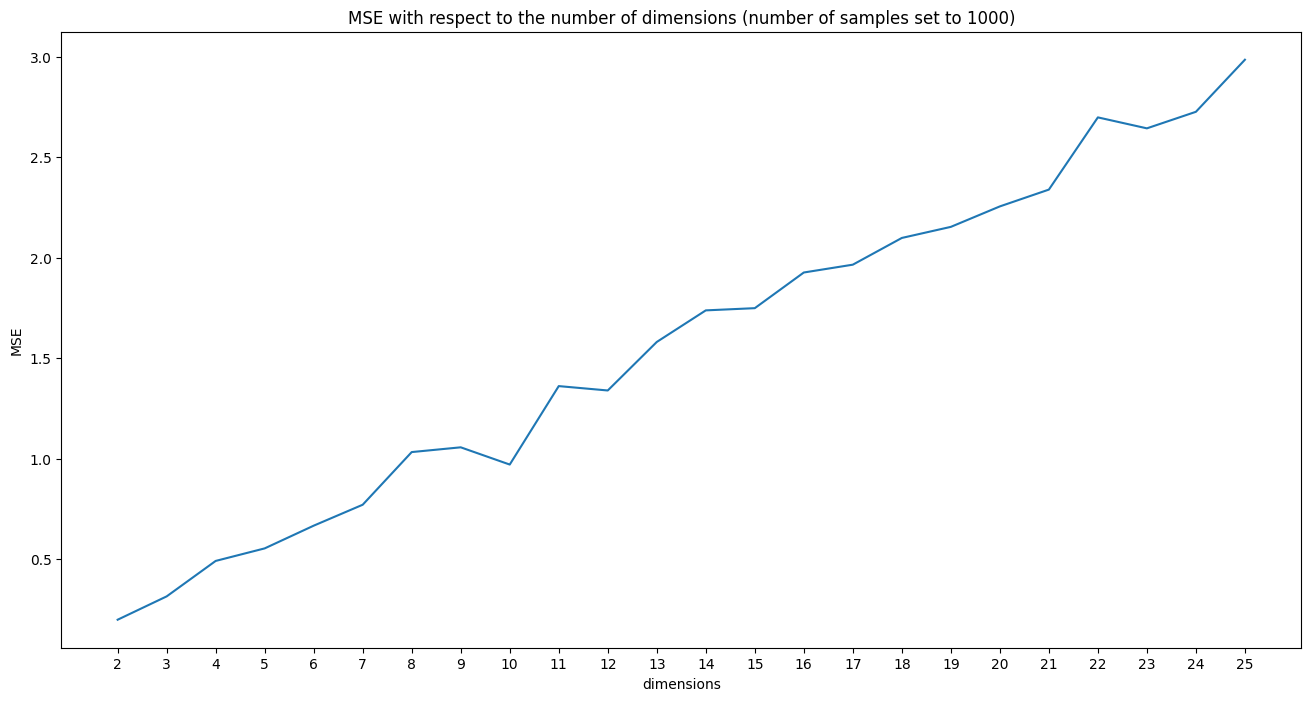

In [115]:
plt.figure(figsize=(16, 8))
plt.plot(DIMENSIONS, mses)
plt.title(f'MSE with respect to the number of dimensions (number of samples set to {NS})')
plt.ylabel('MSE')
plt.xlabel('dimensions')
plt.xticks(DIMENSIONS)
plt.show()

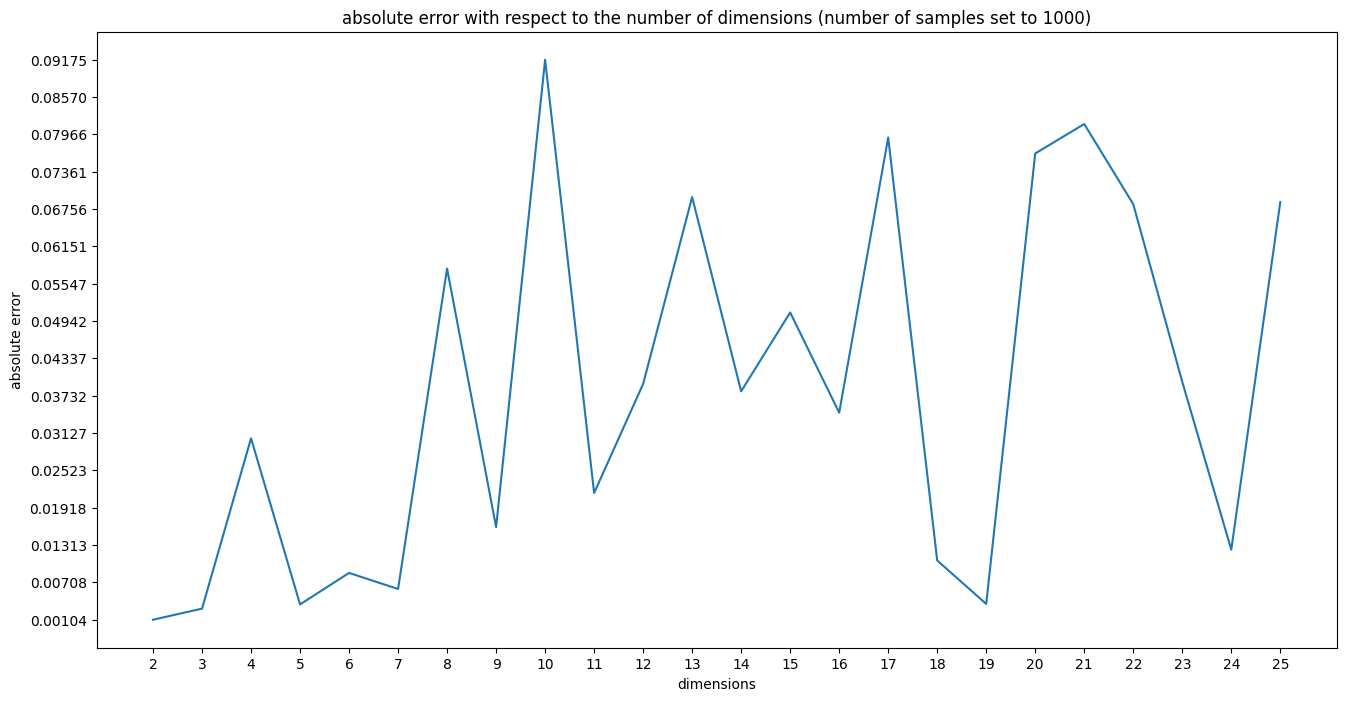

In [116]:
plt.figure(figsize=(16, 8))
plt.plot(DIMENSIONS, estimations)
plt.title(f'absolute error with respect to the number of dimensions (number of samples set to {NS})')
plt.ylabel('absolute error')
plt.xlabel('dimensions')
plt.xticks(DIMENSIONS)
plt.yticks(np.linspace(min(estimations), max(estimations), 16))
plt.show()

Both plots suggest that the larger the number of the dimensions, the less accurate the approximation is. This is very intuitive since the size of the problem increases exponentially with the number of dimensions.